<a href="https://colab.research.google.com/github/rafflds/bons_maus_pagadores_emprestimo/blob/main/Dados_emprestimos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color=red>Imports de bibliotecas

**Instalar bibliotecas**

In [17]:
!pip install imblearn

**Importar**

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize

# Cores e estilos
sns.set_style('darkgrid')
plt.style.use('ggplot')

# suprimir a exibição de mensagens de aviso (warnings)
import warnings
warnings.filterwarnings("ignore")

# Equilibra labels
from imblearn.over_sampling import SMOTE

## <font color=green>Análise Exploratória

In [19]:
# Leitura da base de dados, tradução das colunas. Colando a colunas como cabeçario

base = pd.read_csv('credit_data.csv', encoding='utf-8',
                   names=['id','renda', 'idade', 'divida', 'resposta'],header=0)


# Retirar a coluna "id"

base = base[['renda', 'idade', 'divida','resposta']]

# Visualizar os métricas estatísticas dos dados

base.describe().T


,count,mean,std,min,25%,50%,75%,max
renda,2000.0,45331.600018,14326.327119,20014.48947,32796.459717,45789.117313,57791.281668,69995.685578
idade,1997.0,40.807559,13.624469,-52.42328,28.990415,41.317159,52.587040,63.971796
divida,2000.0,4444.369695,3045.410024,1.37763,1939.708847,3974.719419,6432.410625,13766.051239
resposta,2000.0,0.141500,0.348624,0.00000,0.000000,0.000000,0.000000,1.000000


**Informações gerais sobre a base de dados**

In [20]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   renda     2000 non-null   float64
 1   idade     1997 non-null   float64
 2   divida    2000 non-null   float64
 3   resposta  2000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 62.6 KB


**Quantidade de registros por label**

In [21]:
base.resposta.value_counts()

resposta
0    1717
1     283
Name: count, dtype: int64

**Quantidade de valores duplicados**

In [22]:
duplicated = base.duplicated().sum()
print(f'Quantos valores duplicados: {duplicated}')

Quantos valores duplicados: 0


## <font color=blue>Pré-Processamento Dados

In [23]:
# Visualizar os registros com idade negativa

base.query('idade < 0')

,renda,idade,divida,resposta
15,50501.726689,-28.218361,3977.287432,0
21,32197.620701,-52.423280,4244.057136,0
26,63287.038908,-36.496976,9595.286289,0


**Substituir os valores negativos**

In [24]:
# Substituir os valores negativos, existente na coluna idade, por valores positivos

def substituir_negativo(valor):
  if valor < 0:
    return -valor
  else:
    return valor

# Aplicar a função na coluna idade

base.idade = base.idade.apply(substituir_negativo)
base.query('idade < 0')


,renda,idade,divida,resposta


In [31]:
# Idade mínima passou a ser 18 anos. Antes -52 anos.

base.idade.min().round()

18.0

**Substituir os valores faltantes**

In [29]:
'''
Criar uma variável com média de idade
Aplicar a média dos dados nos valores faltantes
Visualizar a existência dos valores faltantes
'''
mean = base.idade.mean()
base.fillna(mean, inplace=True)

# Visualizar as devidas correções

display('Valores faltantes: ',base.isnull().sum())

'Valores faltantes: '

renda       0
idade       0
divida      0
resposta    0
dtype: int64

**Equilibra os registros da label**

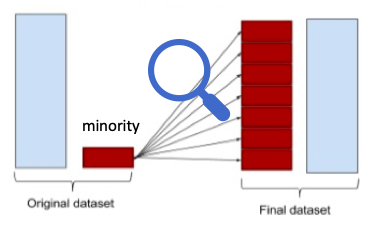

quantidade de dados: (array([0, 1]), array([1717, 1717]))


<Axes: xlabel='resposta', ylabel='count'>

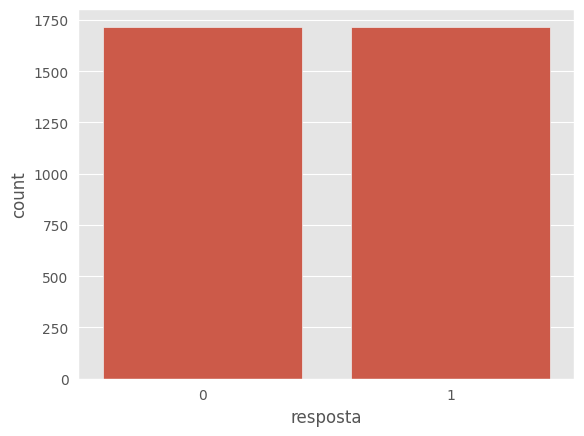

In [30]:
# Saparar a base em features e label
x = base.drop('resposta', axis=1)
y= base.resposta

# Estratégia do modelo será: aumentar a classe minoritária
smote = SMOTE(sampling_strategy='minority')
x, y = smote.fit_resample(x,y)

# Visualização da classe
print(f'quantidade de dados: {np.unique(y, return_counts=True)}')
sns.countplot(x = y)

## <font color=purple>Dashboards

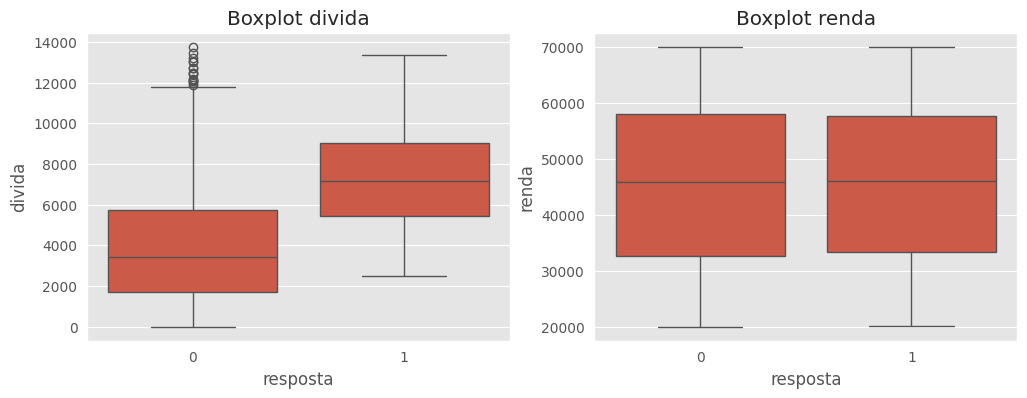

In [10]:
# Tamanho

fig, ax = plt.subplots(1, 2,   figsize=(12,4))

# 1° boxplot

ax[0].set_title('Boxplot divida')
sns.boxplot(x='resposta', y='divida', data=base, ax=ax[0])

# 2° boxplot

ax[1].set_title('Boxplot renda')
sns.boxplot(x='resposta', y='renda', data=base, ax=ax[1])

# visualização

plt.show()


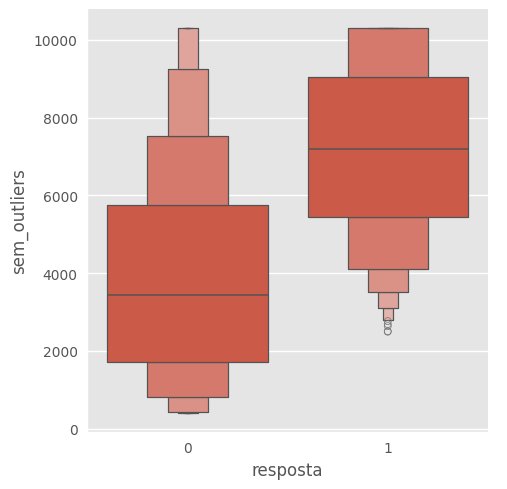

In [32]:
'''Substituir pelos valores no limite superior e inferior do conjunto de dados.
Isso permite suavizar os efeitos dos outliers sem removê-los completamente.'''

base['sem_outliers'] = winsorize(base['divida'], limits=[0.05, 0.05])

# Visualizar o gráfico

sns.catplot(data=base.sort_values("resposta"),
    x="resposta", y="sem_outliers", kind="boxen",
)

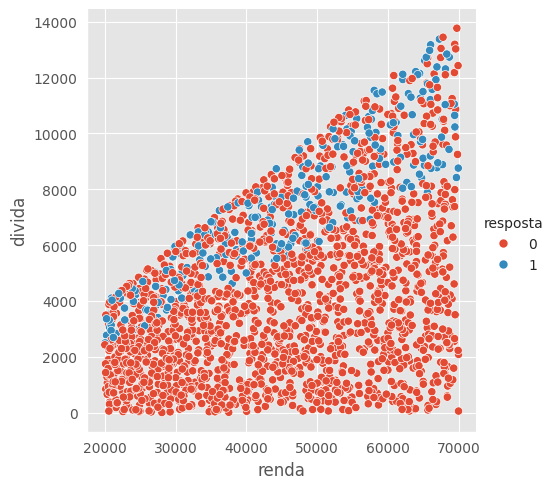

In [12]:
# Relação entre duas variáveis ou conjuntos de dados
# Quanto maior a renda, maior a dívida

sns.relplot(x='renda', y='divida', data=base,hue="resposta")


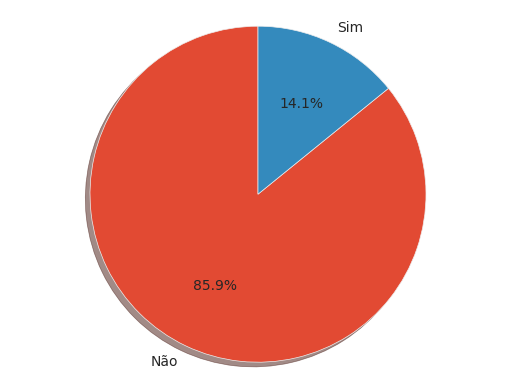

In [13]:
# Distribuição da variável label

fig1, ax1 = plt.subplots()
ax1.pie(base.resposta.value_counts(), labels=['Não', 'Sim'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()


<ipython-input-24-8e167d707c40>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['idade'], y=df['divida'], palette='viridis')


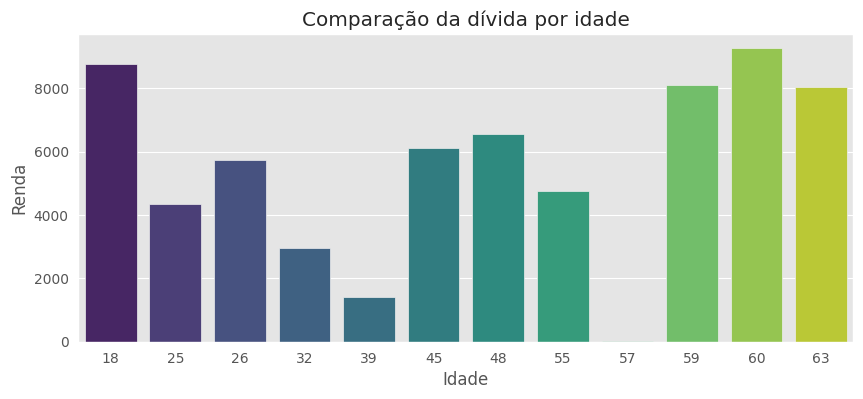

In [24]:
# Converter a coluna idade para inteiro

base['idade'] = base['idade'].astype(int)

# Criar nova variável para usar no gráfico

df = base[['divida', 'idade']].head(12).round(1)

# Criar gráfico de barras

plt.figure(figsize=(10, 4))
sns.barplot(x=df['idade'], y=df['divida'], palette='viridis')
plt.xlabel('Idade')
plt.ylabel('Renda')
plt.title('Comparação da dívida por idade')
plt.show()

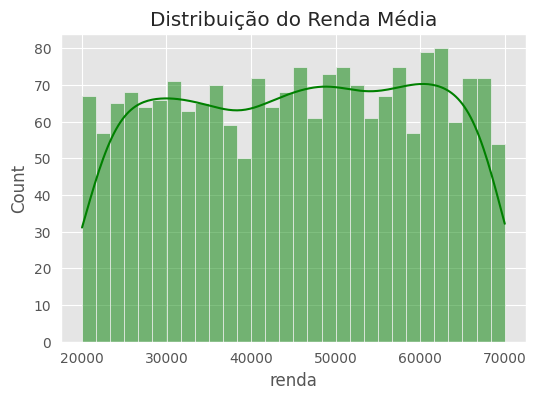

In [18]:
# Visualizar a distribuição de Renda média
plt.figure(figsize=(6, 4))
sns.histplot(base['renda'], bins=30, kde=True, color='green')
plt.title('Distribuição do Renda Média')
plt.show()

## <font color=teal>Análise Preditiva

In [31]:
# Salvar , amostras
import pickle
from sklearn.model_selection import train_test_split

# Validação e score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report


# Machine Learning
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Testes de hipótese
from scipy.stats import shapiro
from scipy import stats